<a href="https://colab.research.google.com/github/Spidey3202/ML-projects/blob/main/Copy_of_Data_Prepare_Houston13_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
!git clone https://github.com/Spidey3202/hybrid-attention/tree/Developing

Cloning into 'Developing'...
fatal: repository 'https://github.com/Spidey3202/hybrid-attention/tree/Developing/' not found


In [2]:
import scipy.io as sio
import numpy as np
import tqdm

In [3]:
import tensorflow as tf

In [4]:
def get_gt_index(y):

  import tqdm

  shapeY = np.shape(y)

  pp,qq = np.unique(y, return_counts=True)
  sum1 = np.sum(qq)-qq[0]

  index = np.empty([sum1,3], dtype = 'int')

  cou = 0
  for k in tqdm.tqdm(range(1,np.size(np.unique(y)))):
    for i in range(shapeY[0]):
      for j in range(shapeY[1]):
        if y[i,j] == k:
          index[cou,:] = np.expand_dims(np.array([k,i,j]),0)
          #print(cou)
          cou = cou+1
  return index

In [5]:
# The code takes the entire hsi/lidar image as input for 'X' and grounttruth file as input for 'y'
# and the patchsize as for 'windowSize'.
# The output are the patches centered around the groundtruth pixel, the corresponding groundtruth label and the
# pixel location of the patch.

def make_patches(X, y, windowSize):

  shapeX = np.shape(X)

  margin = int((windowSize-1)/2)
  newX = np.zeros([shapeX[0]+2*margin,shapeX[1]+2*margin,shapeX[2]])
  print(newX.shape)
  newX[margin:shapeX[0]+margin:,margin:shapeX[1]+margin,:] = X

  index = get_gt_index(y)
  print(index.shape)
  patchesX = np.empty([index.shape[0],2*margin+1,2*margin+1,shapeX[2]], dtype = 'float32')
  patchesY = np.empty([index.shape[0]],dtype = 'uint8')

  for i in range(index.shape[0]):
    p = index[i,1]
    q = index[i,2]
    patchesX[i,:,:,:] = newX[p:p+windowSize,q:q+windowSize,:]
    patchesY[i] = index[i,0]

  return patchesX, patchesY, index

In [8]:
data = sio.loadmat('/content/gdrive/MyDrive/MTP/H13share.mat')

In [9]:
import sys
import numpy

In [10]:
feats =data['hsi']

In [11]:
feats.shape

(349, 1905, 144)

In [12]:
feats_norm = np.empty([349,1905,144], dtype = 'float32')
for i in tqdm.tqdm(range(144)):
  feats_norm[:,:,i] = feats[:,:,i]-np.min(feats[:,:,i])
  feats_norm[:,:,i] = feats_norm[:,:,i]/np.max(feats_norm[:,:,i])

100%|██████████| 144/144 [00:03<00:00, 42.29it/s]


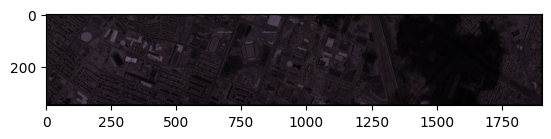

In [13]:
import matplotlib.pyplot as plt
plt.imshow(np.concatenate([np.expand_dims(feats_norm[:,:,105], axis = 2),
                           np.expand_dims(feats_norm[:,:,95], axis = 2),
                           np.expand_dims(feats_norm[:,:,85], axis = 2)], axis = 2))

In [14]:
np.save('feats_norm', feats_norm)

In [15]:
train = data['train']
test = data['test']

In [16]:
# Create train patches

train_patches, train_labels, index_train = make_patches(feats_norm, train, 11)

np.save('train_patches', train_patches)
np.save('train_labels',train_labels)

# Create test patches

test_patches, test_labels, index_test = make_patches(feats_norm, test, 11)

np.save('test_patches', test_patches)
np.save('test_labels',test_labels)

(359, 1915, 144)


100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


(2832, 3)
(359, 1915, 144)


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


(12197, 3)


In [17]:
train_patches.shape

(2832, 11, 11, 144)

In [18]:
def my_ohc(lab_arr):
    lab_arr_unique =  np.unique(lab_arr)
    r,c = lab_arr.shape
    r_u  = lab_arr_unique.shape


    one_hot_enc = np.zeros((r,r_u[0]), dtype = 'float')

    for i in range(r):
        for j in range(r_u[0]):
            if lab_arr[i,0] == lab_arr_unique[j]:
                one_hot_enc[i,j] = 1

    return one_hot_enc

def accuracies(cm):
  import numpy as np
  num_class = np.shape(cm)[0]
  n = np.sum(cm)

  P = cm/n
  ovr_acc = np.trace(P)

  p_plus_j = np.sum(P, axis = 0)
  p_i_plus = np.sum(P, axis = 1)

  usr_acc = np.diagonal(P)/p_i_plus
  prod_acc = np.diagonal(P)/p_plus_j

  theta1 = np.trace(P)
  theta2 = np.sum(p_plus_j*p_i_plus)
  theta3 = np.sum(np.diagonal(P)*(p_plus_j + p_i_plus))
  theta4 = 0
  for i in range(num_class):
    for j in range(num_class):
      theta4 = theta4+P[i,j]*(p_plus_j[i]+p_i_plus[j])**2

  kappa = (theta1-theta2)/(1-theta2)

  t1 = theta1*(1-theta1)/(1-theta2)**2
  t2 = 2*(1-theta1)*(2*theta1*theta2-theta3)/(1-theta2)**3
  t3 = ((1-theta1)**2)*(theta4 - 4*theta2**2)/(1-theta2)**4

  s_sqr = (t1+t2+t3)/n

  return ovr_acc, usr_acc, prod_acc, kappa, s_sqr

In [30]:
# Import Relevant libraries and classes
import scipy.io as sio
import numpy as np
import tqdm
from sklearn.decomposition import PCA
import tensorflow as tf
keras = tf.keras
from keras import backend as K
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout
from keras.layers import Conv2D, Flatten, Lambda, Conv3D, Conv3DTranspose,BatchNormalization,Conv1D, Activation
from keras.layers import Reshape, Conv2DTranspose, Concatenate, Multiply, Add, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Input, Concatenate, Conv2D, BatchNormalization, Activation, Multiply, Lambda, multiply
from keras import Model
from keras.datasets import mnist
from keras.losses import MeanSquaredError, binary_crossentropy
from keras import backend as K
#from keras.utils import plot_model
from keras import backend as K
from sklearn.metrics import confusion_matrix

In [21]:
train_patches = np.load('train_patches.npy')
test_patches = np.load('test_patches.npy')

train_labels = np.load('train_labels.npy')-1
test_labels = np.load('test_labels.npy')-1

tr90 = np.empty([2832,11,11,144], dtype = 'float32')
tr180 = np.empty([2832,11,11,144], dtype = 'float32')

In [22]:
for i in tqdm.tqdm(range(2832)):
  tr90[i,:,:,:] = np.rot90(train_patches[i,:,:,:])
  tr180[i,:,:,:] = np.rot90(tr90[i,:,:,:])

100%|██████████| 2832/2832 [00:00<00:00, 16578.39it/s]


In [23]:
train_patches = np.concatenate([train_patches, tr180], axis = 0)
train_labels = np.concatenate([train_labels,train_labels], axis = 0)

from sklearn.utils import shuffle
train_patches, train_labels = shuffle(train_patches, train_labels, random_state=0)

print(np.shape(train_patches))
print(np.shape(test_patches))

(5664, 11, 11, 144)
(12197, 11, 11, 144)


In [24]:
train_labels[:10]

array([12,  9,  8, 13,  8, 13, 12,  7, 13, 13], dtype=uint8)

In [39]:
def ham_block(input_feature, name):
    attention_feature, channel = channel_attention(input_feature, 'ch_at', gamma=2, b=1)
    attention_feature = spatial_attention(attention_feature, channel, 'sp_at')
    return attention_feature

# channel attention submodule
def channel_attention(input_feature, name, gamma=2, b=1):
    with tf.name_scope(name):
        alpha = tf.Variable([0.5], dtype='float32', name='alpha')
        beta = tf.Variable([0.5], dtype='float32', name='beta')
        avg_pool = GlobalAveragePooling2D()(input_feature)
        max_pool = GlobalMaxPooling2D()(input_feature)
        N, H, W, C = input_feature.shape
        C = int(C)
        assert avg_pool.shape.as_list() == [None, C]
        assert max_pool.shape.as_list() == [None, C]

        # Adaptive Mechanism Block
        add = (avg_pool + max_pool) / 2 + alpha * avg_pool + beta * max_pool
        assert add.shape.as_list() == [None, C]

        # fast one-dimensional convolutional layer
        t = int(abs(np.log2(C) + b) / gamma)
        k = t if t % 2 else t + 1
        add = Reshape((1, 1, C))(add)
        add_conv1d = Conv1D(C, kernel_size=k, strides=1, padding='same', use_bias=False)(add)
        add_conv1d = Reshape((1, 1, C))(add_conv1d)
        assert add_conv1d.shape.as_list() == [None, 1, 1, C]
        channel = Lambda(lambda x: K.sigmoid(x))(add_conv1d)

        output_feature = multiply([input_feature, channel])
    return output_feature, channel


# spatial attention submodule
def spatial_attention(input_feature, channel, name):
    kernel_size = 7
    keep_rate = 0.6
    C = channel.get_shape()[-1]
    C = int(C)
    h = int(C * keep_rate)
    if h % 2 == 1:
        k = h + 1
    else:
        k = h
    t = C - k

    # channel separation technique
    channel_top, channel_top_index = tf.nn.top_k(channel, k)
    kth = tf.reduce_min(channel_top, axis=3, keepdims=True)
    topk = tf.greater_equal(channel, kth)
    lessk = tf.less(channel, kth)
    im_mask = tf.cast(topk, dtype=tf.float32)
    sub_mask = tf.cast(lessk, dtype=tf.float32)
    input_feature_immask = Multiply()([input_feature, im_mask])
    input_feature_submask = Multiply()([input_feature, sub_mask])

    # important group
    avg_pool_im = Lambda(lambda x: tf.reduce_sum(x, axis=[3], keepdims=True))(input_feature_immask)
    avg_pool_im = Lambda(lambda x: tf.divide(x, k))(avg_pool_im)
    assert avg_pool_im.shape[-1] == 1
    max_pool_im = Lambda(lambda x: tf.reduce_max(x, axis=[3], keepdims=True))(input_feature_immask)
    assert max_pool_im.shape[-1] == 1
    concat_im = Concatenate(axis=3)([avg_pool_im, max_pool_im])
    assert concat_im.shape[-1] == 2
    concat_im = Conv2D(filters=1,
                       kernel_size=(kernel_size, kernel_size),
                       strides=(1, 1),
                       padding='same',
                       activation=None,
                       kernel_initializer='he_normal',
                       use_bias=False)(concat_im)
    assert concat_im.shape[-1] == 1
    concat_im = BatchNormalization()(concat_im)
    concat_im = Activation('relu')(concat_im)
    concat_im = Activation('sigmoid')(concat_im)
    spatial_im = Multiply()([input_feature_immask, concat_im])

    # sub-important group
    avg_pool_sub = Lambda(lambda x: tf.reduce_sum(x, axis=[3], keepdims=True))(input_feature_submask)
    avg_pool_sub = Lambda(lambda x: tf.divide(x, t))(avg_pool_sub)
    assert avg_pool_sub.shape[-1] == 1
    max_pool_sub = Lambda(lambda x: tf.reduce_max(x, axis=[3], keepdims=True))(input_feature_submask)
    assert max_pool_sub.shape[-1] == 1
    concat_sub = Concatenate(axis=3)([avg_pool_sub, max_pool_sub])
    assert concat_sub.shape[-1] == 2
    concat_sub = Conv2D(filters=1,
                        kernel_size=(kernel_size, kernel_size),
                        strides=(1, 1),
                        padding='same',
                        activation=None,
                        use_bias=False)(concat_sub)
    assert concat_sub.shape[-1] == 1
    concat_sub = BatchNormalization()(concat_sub)
    concat_sub = Activation('relu')(concat_sub)
    concat_sub = Activation('sigmoid')(concat_sub)
    spatial_sub = Multiply()([input_feature_submask, concat_sub])

    final_spatial = spatial_im + spatial_sub

    return final_spatial

In [40]:
def my_conv(x,l):

  c1 = l(x)
  c1 = BatchNormalization()(c1)

  return c1

def block(x,k):

  fil = 32
  #k = 3

  x2 = Conv2D(filters=fil, kernel_size=1,  padding = 'valid',
                       activation = 'relu')(x)

  l1 = Conv2D(filters=fil, kernel_size=k,  padding = 'same',
                       activation = 'relu')
  l2 = Conv2D(filters=fil, kernel_size=k,  padding = 'same',
                       activation = 'relu')
  l3 = Conv2D(filters=fil, kernel_size=k,  padding = 'same',
                       activation = 'relu')
  l4 = Conv2D(filters=fil, kernel_size=k,  padding = 'same',
                       activation = 'relu')


  # Stage 1

  cv1 = my_conv(x2, l1)
  c1 = Add()([x2,cv1])
  cv2 = my_conv(c1, l2)
  c2 = Add()([x2,cv1,cv2])
  cv3 = my_conv(c2, l3)
  c3 = Add()([x2,cv1,cv2,cv3])
  cv4 = my_conv(c3, l4)

  # Stage 2

  c4 = Add()([cv2,cv3,cv4])
  cv1 = my_conv(c4, l1)
  c5 = Add()([cv1,cv3,cv4])
  cv2 = my_conv(c5, l2)
  c6 = Add()([cv1,cv2,cv4])
  cv3 = my_conv(c6, l3)
  c7 = Add()([cv1,cv2,cv3])
  cv4 = my_conv(c7, l4)

  conc1 = Concatenate(axis = 3)([cv1,cv2,cv3, cv4])
  conc1 = ham_block(conc1, 'ham_block')

  gap1 = GlobalAveragePooling2D()(conc1)

  return conc1, gap1

def ext(x):

  conc1, gap1 = block(x,3)
  conc2, gap2 = block(x,5)
  conc3, gap3 = block(x,7)

  gp = Concatenate(axis = 1)([gap1, gap2, gap3])
  c6 =  Dense(15, activation = 'softmax')(gp)
  return Reshape([15])(c6)

x = Input(shape=(11,11,144), name='inputA')

outfinal = ext(x)

optim = keras.optimizers.Nadam(0.0002)

model = Model(x, outfinal, name = 'model')

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model)

AttributeError: 'tuple' object has no attribute 'as_list'

In [ ]:
import sys
import numpy as np

train_accuracy_list = []
val_accuracy_list = []


for p in range(1):

  x = Input(shape=(11,11,144), name='inputA')

  outfinal = ext(x)

  optim = keras.optimizers.Nadam(0.0002)

  model = Model(x, outfinal, name = 'model')
  print(x.shape)

  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  ep = 0
  k=0
  import gc
  for epoch in (range(100)):
    gc.collect()
    h = model.fit(x = train_patches[:,:,:,0:144],
                    y = my_ohc(np.expand_dims(train_labels, axis = 1)),
                    epochs=1, batch_size = 64, verbose = 1)
    # print(len(h.history['accuracy']))
    train_accuracy_list.append(h.history['accuracy'])
    preds2 = model.predict(test_patches[:,:,:,0:144], batch_size = 64, verbose = 2)

    conf = confusion_matrix(test_labels, np.argmax(preds2,1))
    ovr_acc, _, _, _, _ = accuracies(conf)
    val_accuracy_list.append(ovr_acc)

    print("-"*40," EPOCH : ", epoch,"-"*40)
    print("-"*20, " Train accuracy : ", np.round(100*np.array(h.history['accuracy']),2))
    print("-"*20, " Test Accuracy : ", np.round(100*ovr_acc,2))


    if ovr_acc>=k:
      model.save('cn_share_ms_ab16/model'+str(p))
      k = ovr_acc
      ep = epoch
      np.save('cn_share_ms_ab16/ep',epoch)
    print('acc_max = ', np.round(100*k,2), '% at epoch', ep)

    if epoch%5==0:
      model.save('cn_share_ms_ab16/model_temp')
      np.save('cn_share_ms_ab16/ep_temp',epoch)

In [ ]:
test_patches

In [ ]:
p = test_patches[0:11, 0:11, 0:144]

In [ ]:
p.shape

In [ ]:
ta = np.array(train_accuracy_list)
va = np.array(val_accuracy_list)

np.savetxt(conf, "/content/gdrive/MyDrive/conf.txt")
np.savetxt(ta, "/content/gdrive/MyDrive/ta.txt")
np.savetxt(va, "/content/gdrive/MyDrive/va.txt")

In [ ]:
feats.shape

new_feats =

In [ ]:
11*31, 173*11

In [ ]:
color_dict = {
    0 : [0,125,0],
    1 :[0,109,140],
    2 : [0,198,0],
    3 : [0,78,0],
    4 : [93,43,0],
    5 : [0,2,156],
    6 : [255,255,255],
    7 : [255,237,0],
    8 : [160,160,160],
    9 : [143,0,0],
    10 : [144,0,118],
    11 : [255,204,200],
    12 : [255,124,0],
    13 : [224,0,180],
    14 : [224,0,180],
}

In [ ]:
from tqdm import tqdm

feats_map = np.zeros((341, 1903, 3))
b = 32
for i in range(0, 341):
  for j in tqdm(range(0, 1892)):
    y = model(feats_norm[i:i+11, j:j+11, :].reshape(1,11,11,144))
    c = np.argmax(y.numpy())
    r,g,b = color_dict[c]
    feats_map[i+5, j+5,0] = r
    feats_map[i+5, j+5,1] = g
    feats_map[i+5, j+5,2] = b

# patch = feats[0:11, 0:11, 0:144].reshape(1,11,11,144)

In [ ]:
plt.imshow(feats_map)

In [ ]:
plt.imshow(feats_norm[:,:,105])

In [ ]:
plt.imshow(feats[:,:,143])

In [ ]:
np.max(feats_norm), np.max(feats)

In [ ]:
y = model(patch)

In [ ]:
y

In [ ]:
np.argmax(y.numpy())

### Inference of model

In [ ]:
## Load Model here
model = tf.keras.models.load_model('/content/cn_share_ms_ab16/model_temp')

In [ ]:
## Load Dataset here
x = test_patches[:, :, :, :]

## Predict model output here
y = model(x)

In [ ]:
## Shape of Output
print(x.shape)
print(y.shape)

In [ ]:
## Labels separation
y_labels = np.argmax(y, axis=1)
y_labels.shape, test_labels.shape

In [ ]:
pred_expanded = tf.expand_dims(y_labels, axis=1)
truth_expanded = tf.expand_dims(test_labels, axis=1)

In [ ]:
pred = tf.repeat(pred_expanded, 11*11, axis=1)
truth = tf.repeat(truth_expanded, 11*11, axis=1)

In [ ]:
pred = tf.reshape(pred, (-1, 11, 11))
truth = tf.reshape(truth, (-1, 11, 11))

In [ ]:
!pip install patchify

In [ ]:
from patchify import unpatchify

seg_mask = unpatchify(pred, )

In [ ]:
data = sio.loadmat('/content/gdrive/MyDrive/H13share.mat')

### Plot Image

In [ ]:
(data['hsi'].shape[0] + 9)/11, (data['hsi'].shape[1] + 10)/11

In [ ]:
import matplotlib.pyplot as plt

channel = data['hsi'][:,:,110]

plt.imshow(channel, cmap="gray")
plt.axis("off")